# Risk Premia Portfolio Backtest

In this notebook we backtest a couple of classic long-only risk premia harvesting strategies:

1. Capital weighted
2. Equal Risk Contribution (ERC) weighted

We then go on to optimise the trade buffer parameter for out favoured strategy.

Rebalancing in both strategies occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

Capital is re-invested using the square root of profits money manager.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended. Contrast with a percentage commission scheme where trading back to the trade buffer limit is considered optimal.

In [48]:
import os
import sys
import importlib
from pathlib import PurePath
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [49]:
# Import local modules
sys.path.append(str(PurePath(os.getcwd()).parent))

import alphasim.backtest as bt
importlib.reload(bt)

import alphasim.commission as fee
importlib.reload(fee)

import alphasim.money as mo
importlib.reload(mo)

import alphasim.stats as stats
importlib.reload(stats)

<module 'alphasim.stats' from '/Users/richklee/repos/github.com/richklee/alphasim/alphasim/stats.py'>

In [50]:
# Download price data for our universe
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2005-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2005-01-03,41.982758,50.943657,43.020000
2005-01-04,41.423946,50.409779,42.740002
2005-01-05,41.137375,50.679512,42.669998
2005-01-06,41.334385,50.713982,42.150002
2005-01-07,41.201843,50.828800,41.840000
...,...,...,...
2022-11-15,200.360001,99.230003,165.500000
2022-11-16,198.320007,101.400002,165.119995
2022-11-17,197.490005,100.330002,163.919998


## Dollar Weighted

Define equal dollar weights for our portfolio.

In [51]:
dollar_weight_df = price_df.copy()
dollar_weight_df[:] = [0.333, 0.333, 0.333]

## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [52]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

# Calc required time series
ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()
cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [53]:
# Function to calculate ERC weights for each period
def calc_erc_weight(initial_weights, cov_mat, b):
    if np.isnan(initial_weights).any():
        n = len(initial_weights)
        initial_weights = np.full(n, len(initial_weights)/n)
    w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    return w

In [54]:
# Define our risk budget as equal risk
risk_budget = np.full(ticker_n, 1/ticker_n)

# Get ERC weights
erc_weight_df = ret_df[:-1].copy()
erc_weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(
    erc_weight_df.shift(1).values, cov_mat, repeat(risk_budget))]
erc_weight_df = erc_weight_df.dropna()
display(erc_weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2005-01-04,0.366656,0.149186,0.484158
2005-01-05,0.219042,0.126446,0.654512
2005-01-06,0.199064,0.114435,0.686500
2005-01-07,0.212974,0.215017,0.572009
2005-01-10,0.282464,0.234229,0.483307
...,...,...,...
2022-11-14,0.260203,0.348211,0.391586
2022-11-15,0.262066,0.344461,0.393473
2022-11-16,0.263696,0.343658,0.392646


## Backtest

In [55]:
# Define a simple fixed minimum commission scheme whereby every trade costs 10 of the quote currency
def fixed_commission(trade_size, trade_value):
    return fee.fixed_commission(trade_size, trade_value, 10)

In [56]:
# Execute our backtest for the dollar weighted strategy
dw_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=dollar_weight_df.copy(),
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=fixed_commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [57]:
# Align the length of prices and weights
price_df = price_df.align(erc_weight_df, axis=0, join='inner')[0]

# Execute our backtest for the ERC strategy
erc_result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=erc_weight_df.copy(),
    trade_buffer=0.05, 
    do_trade_to_buffer=False, 
    commission_func=fixed_commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

In [58]:
# Compare performance stats
dw_stat_df = stats.calc_stats(dw_result_df)
erc_stat_df = stats.calc_stats(erc_result_df)
display(pd.concat([dw_stat_df, erc_stat_df], keys=["dollar_weighted", "erc_weighted"], axis=1))

,dollar_weighted,erc_weighted
,result,result
start,2005-01-03 00:00:00,2005-01-04 00:00:00
end,2022-11-21 00:00:00,2022-11-18 00:00:00
initial,10000.0,10000.0
final,28444.045604,26467.984224
profit,18444.045604,16467.984224
cagr,0.04116,0.038295
ann_volatility,0.071726,0.063908
ann_sharpe,0.573845,0.599218
commission,-530.0,-2120.0


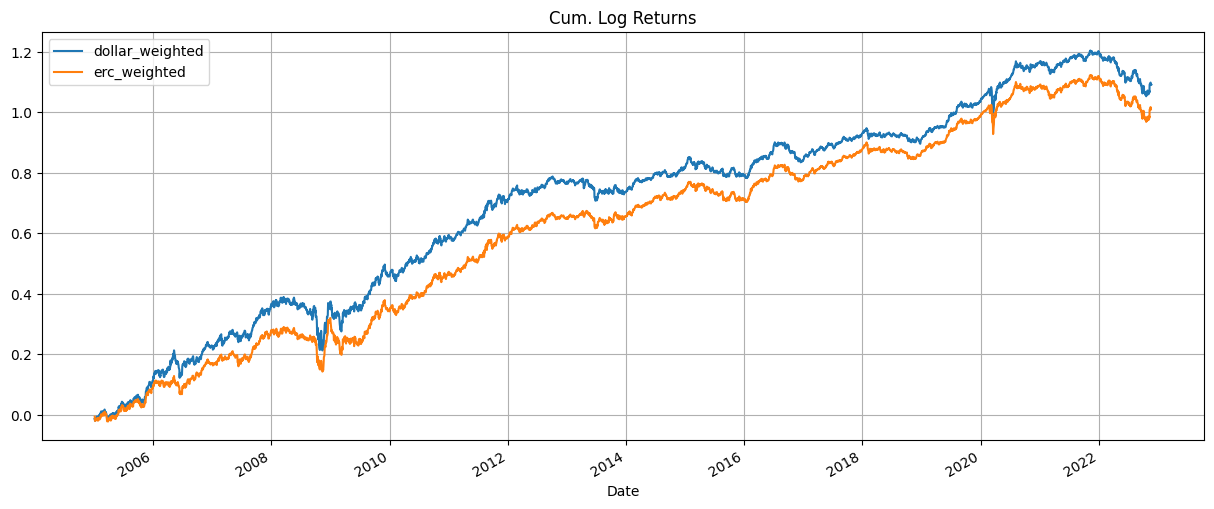

In [59]:
cum_sum_df = pd.concat([
    stats.calc_returns(dw_result_df).cumsum(),
    stats.calc_returns(erc_result_df).cumsum()
], keys=["dollar_weighted", "erc_weighted"], axis = 1)

ax = cum_sum_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

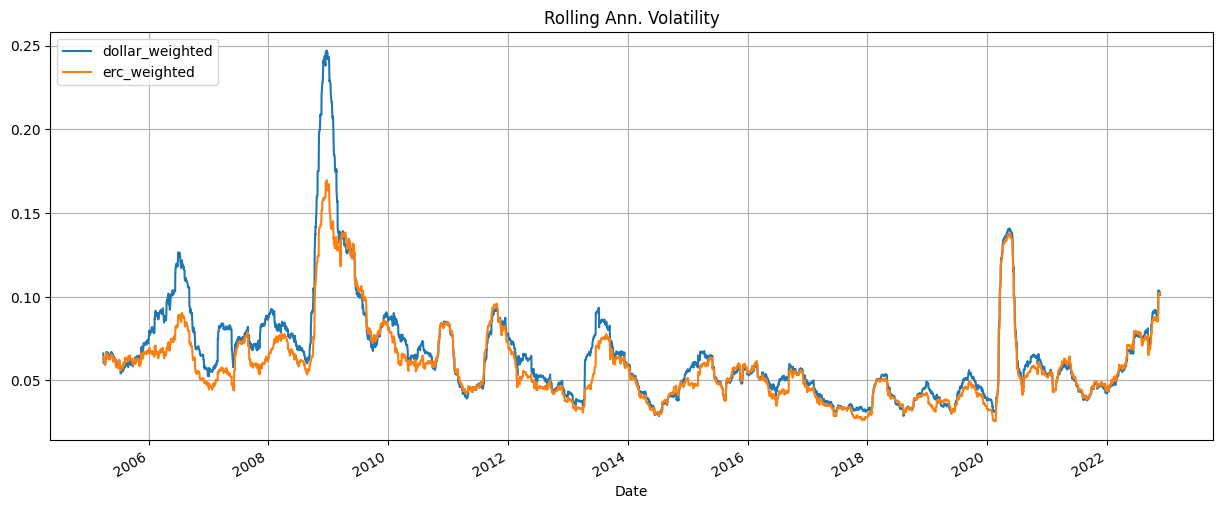

In [60]:
vola_df = pd.concat([
    stats.calc_returns(dw_result_df).rolling(window=60).std() * np.sqrt(252),
    stats.calc_returns(erc_result_df).rolling(window=60).std() * np.sqrt(252),
], keys=["dollar_weighted", "erc_weighted"], axis = 1)

ax = vola_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling Ann. Volatility')
plt.legend(loc=2)
plt.show()

## Choosing a strategy

Despite the drag on profit from the extra trading costs, the ERC strategy enjoys better risk-adjusted returns than the simpler dollar weighted strategy.

This is in part due to the lower volatility of the ERC strategy.

## Optimsing trade buffer

Analysing the trade buffer by risk-adjusted returns indicates a buffer of 10% would give optimal returns.

In [61]:
price_df = price_df.align(erc_weight_df, axis=0, join='inner')[0]

trade_buffers = [0, 0.02, 0.04, 0.06, 0.08, 0.1]

sharpes = np.array([])

for tb in trade_buffers:

    df = bt.backtest(
        prices=price_df.copy(), 
        weights=erc_weight_df.copy(),
        trade_buffer=tb, 
        do_trade_to_buffer=False, 
        commission_func=fixed_commission,
        initial_capital=10000,
        money_func=mo.sqrt_profit)

    sharpes = np.append(sharpes, [stats.calc_stats(df).T["ann_sharpe"]])

,trade_buffer,sharpe
0,0.00,-0.937995
1,0.02,0.377362
2,0.04,0.59142
3,0.06,0.632622
4,0.08,0.644277
5,0.10,0.648782


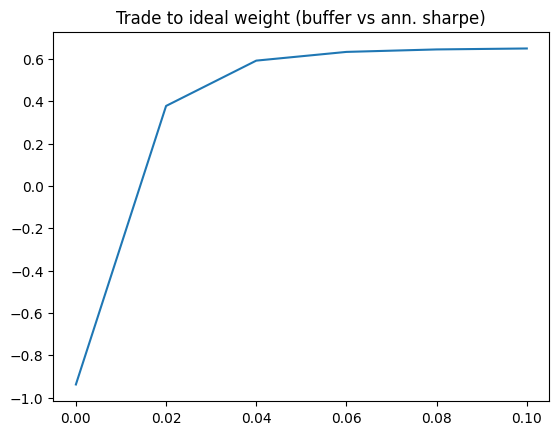

In [62]:
result_df = pd.DataFrame()
result_df["trade_buffer"] = trade_buffers
result_df["sharpe"] = sharpes
display(result_df)

plt.plot(result_df["trade_buffer"], result_df["sharpe"])
plt.title('Trade to ideal weight (buffer vs ann. sharpe)')
plt.show()

In [63]:
optima_tb = 0.1

result_df = bt.backtest(
    prices=price_df.copy(), 
    weights=erc_weight_df.copy(),
    trade_buffer=optima_tb, 
    do_trade_to_buffer=False, 
    commission_func=fixed_commission,
    initial_capital=10000,
    money_func=mo.sqrt_profit)

An improved sharpe and CAGR is clear when comparing the optima and original ERC strategy.

In [64]:
optima_stat_df = stats.calc_stats(result_df)
display(pd.concat([optima_stat_df, erc_stat_df], keys=["optima", "original_erc"], axis=1))

,optima,original_erc
,result,result
start,2005-01-04 00:00:00,2005-01-04 00:00:00
end,2022-11-18 00:00:00,2022-11-18 00:00:00
initial,10000.0,10000.0
final,28851.49495,26467.984224
profit,18851.49495,16467.984224
cagr,0.041757,0.038295
ann_volatility,0.064363,0.063908
ann_sharpe,0.648782,0.599218
commission,-670.0,-2120.0


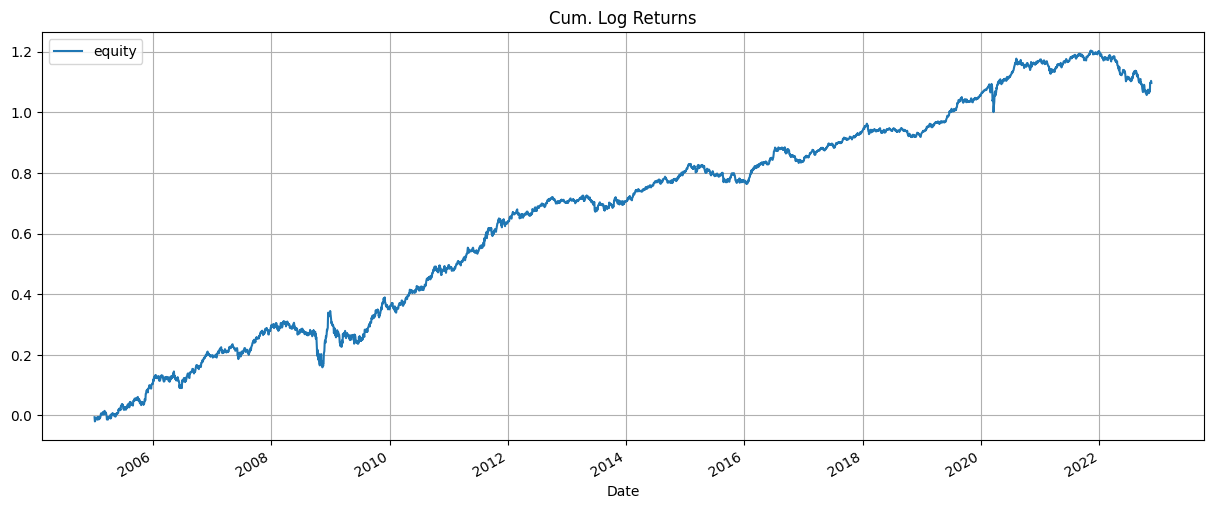

In [65]:
ret_df = stats.calc_returns(result_df)
ax = ret_df.cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

Note the large rebalances indicated by the right angle change in assets weights. A smaller trade buffer would result in more frequent trades and less abrupt changes in portfolio weights, but at the expense of risk-adjusted returns in this case.

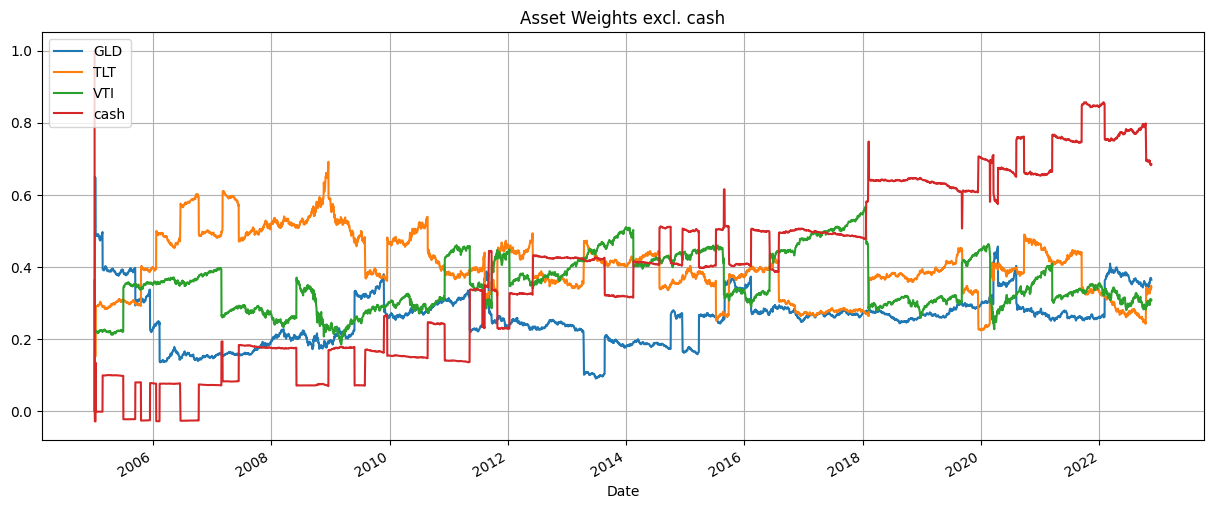

In [66]:
ticker_weight_df = result_df["start_weight"].unstack()
ax = ticker_weight_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Asset Weights')
plt.legend(loc=2)
plt.show()